# IMEC2001 Herramientas Computacionales 
## Semana 8: Transformada Rápida de Fourier (FFT)
### Clase 15: FFT

Universidad de los Andes — Mayo 24 y 26, 2023.

---

## TABLA DE CONTENIDO

### Sección 1: FFT [→](#section1)
- 1.1. Introducción
- 1.2. Cargar Librerías
- 1.3. Ejemplo 1: Datos Medidos
    - 1.3.1. Señal 1
    - 1.3.2. Señal 4
    - 1.3.3. Señal 5
- 1.4. Ejemplo 2: Audio

### Sección 2: Sistemas Dinámicos [→](#section2)
- 2.1. Introducción
- 2.2. Ejemplo 1: Péndulo Simple
- 2.3. Ejemplo 2: Péndulo Simple + Fricción + Fuerza Externa
___

<a id="section1"></a>
# Sección 1: FFT

## 1.1. Introducción

La onda de una señal en el tiempo se puede describir a partir de los siguientes parámetros:
- Amplitud $A_m$.
- Frecuencia angular $\omega$.
- Ángulo de fase $\phi$.

Así, la ecuación que la describe es:

$$
s(t) = A_m \cdot \sin (\omega t + \phi)
$$

Al ver gráficamente el comportamiento de la señal, es más sencillo entender su **periodo** $T$ que la frecuencia angular $\omega$. Luego, tenemos la siguiente relación:

$$
\omega = \frac{2 \pi}{T}
$$

<img src='./img/señal.png' width='500' height='500'/>

Pero, qué sucede si tenemos varias ondas juntas en la misma señal en el tiempo, ¿cómo las podemos describir?

<img src='./img/señal_tiempo.png' width='500' height='500'/>

Aquí entra en escena la **Transformada Discreta de Fourier** (DFT, por sus siglas en inglés). Este es un algoritmo que transforma una función matemática en otra, obteniendo una representación en el dominio de la frecuencia, siendo la función original una función en el dominio del tiempo.

La representación en el dominio de la frecuencia es la descripción descompuesta de la onda de la señal original, es decir, descompone una señal en sus componentes espectrales individuales y así proporciona información sobre su composición. 

La representación matemática de la señal original es:

$$
f(t) = A_0 + A_1 \sin(\omega t + \phi_1) + A_2 \sin(2 \omega t + \phi_2) + ... + A_n \sin(n \omega t + \phi_n)
$$

Para llegar a esta solución, debemos conocer:
- El periodo $T$ de la señal.
- La cantidad de datos $N$ requeridos para comlpetar cada periodo.
- La frecuencia de muestreo (también llamado el *paso de frecuencias* o *resolución de frecuencias*), determinado como $\Delta f = 1/T$.
- La frecuencia circular $\omega = 2 \pi / T$.

La **Transformada Rápida de Fourier** (FFT, por sus siglas en inglés) es un algoritmo que reduce considerablemente el tiempo de cálculo de la DFT.

Aprovecharemos la librería `scipy.fft` para comprender de forma práctica y eficiente qué es la FFT y cómo la podemos aplicar al trabajar con señales en el tiempo.

<div class='alert alert-block alert-info'> 

<i class='fa fa-info-circle' aria-hidden='true'></i>
Puede obtener más información en la documentación oficial de la librería `scipy.io.wavfile` dando clic [aquí](https://docs.scipy.org/doc/scipy/tutorial/fft.html).
</div>

¡Empecemos!

## 1.2. Cargar Librerías

In [1]:
# Datos y Gráficas
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import integrate

# FFT
from scipy import fft
from scipy.fftpack import fftfreq

## 1.3. Ejemplo 1: Datos Medidos

Tenemos cinco señales diferentes en el tiempo y queremos caracterizar cada una de ellas de forma independiente utilizando la FFT mediante la librería `scipy.fft`.

In [2]:
df = pd.read_excel(io='./data/señales.xlsx', 
                   sheet_name='Hoja1') # ./ es pwd()

df.head()

,item,tiempo_ms,f1,f2,f3,f4,f5,f6
0,1,0,5.40,3.76,10.20,4.00,-9.40,10.10
1,2,1,4.74,3.88,10.00,2.58,-6.80,9.34
2,3,2,3.01,4.19,9.83,0.99,-3.50,8.32
3,4,3,0.80,4.54,9.57,1.54,-0.20,7.05
4,5,4,-1.20,4.67,9.26,4.40,2.52,5.57


### 1.3.1. Señal 1

In [3]:
def formato_grafica(titulo, ejex, ejey, leyenda=False, xlim=[None, None], ylim=[None, None]):
    plt.rcParams['axes.axisbelow'] = True

    plt.title(titulo, fontsize=15)
    plt.ylabel(ejey, fontsize=13)
    plt.xlabel(ejex, fontsize=13)

    plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
    plt.xticks(rotation=0)
    plt.minorticks_on()
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(xlim[0], xlim[1])
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', alpha=0.2)
    
    if leyenda == True:
        plt.legend(loc='best')
    
    plt.tight_layout;

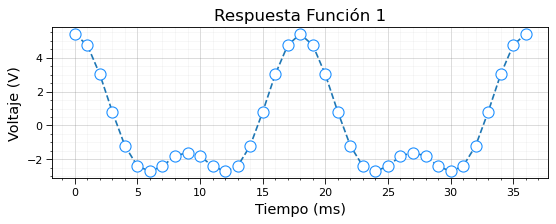

In [4]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(df['tiempo_ms'], df['f1'], linestyle='--', marker='o', markerfacecolor='white', markeredgecolor='dodgerblue', ms=10)

formato_grafica(titulo='Respuesta Función 1', 
                ejex='Tiempo (ms)', 
                ejey='Voltaje (V)',
                leyenda=False)

Recordemos que para poder implementar la FFT, debemos conocer:
- El periodo $T$ de la señal.
- La cantidad de datos $N$ requeridos para comlpetar cada periodo.
- La frecuencia de muestreo (también llamado el *paso de frecuencias* o *resolución de frecuencias*), determinado como $\Delta f = 1/T$.
- La frecuencia circular $\omega = 2 \pi / T$.

In [5]:
# Periodo
T = 18 # ms

# Cantidad de datos
N = len(df['f1'])

# Frecuencia de muestreo
def frec_muestreo(T):
    return 1/T

delta_f = frec_muestreo(T) # Hz

# Frecuencia Circular
def freq_circular(T):
    return 2*np.pi / (T/1000)

omega = freq_circular(T) # rad/s
omega

349.0658503988659

Para emplear la librería `scipy.fft` se requiere conocer (i.) la señal y (ii.) la frecuencia de muestreo. La sintaxis es:

In [6]:
import scipy

In [7]:
# PASO 1. Estimar la FFT
señal_fft = fft.fft(df['f1'].values)
señal_fft

array([ 5.20000000e+00 -0.j        ,  6.57894669e+00 +0.55995089j,
        6.68253862e+01+11.45836322j,  9.41268607e-01 +0.24508728j,
        3.19459362e+01+11.2872173j , -4.16180282e+00 -1.88125349j,
       -1.90968554e+00 -1.06681435j, -1.00136828e+00 -0.67680683j,
       -5.74342003e-01 -0.46374878j, -4.80227480e-01 -0.46026076j,
       -4.17147103e-01 -0.47397118j, -1.52683322e-01 -0.20644148j,
       -7.65368089e-02 -0.12430368j, -9.26849961e-02 -0.18382972j,
       -9.13205889e-03 -0.022726j  , -7.85466067e-02 -0.2564816j ,
       -6.29543912e-02 -0.2921094j ,  1.76473535e-02 +0.13781072j,
        7.92635404e-03 +0.18659255j,  7.92635404e-03 -0.18659255j,
        1.76473535e-02 -0.13781072j, -6.29543912e-02 +0.2921094j ,
       -7.85466067e-02 +0.2564816j , -9.13205889e-03 +0.022726j  ,
       -9.26849961e-02 +0.18382972j, -7.65368089e-02 +0.12430368j,
       -1.52683322e-01 +0.20644148j, -4.17147103e-01 +0.47397118j,
       -4.80227480e-01 +0.46026076j, -5.74342003e-01 +0.463748

In [8]:
# PASO 2. Estimar las frecuencias
frecs = fftfreq(N, delta_f)
frecs

array([ 0.        ,  0.48648649,  0.97297297,  1.45945946,  1.94594595,
        2.43243243,  2.91891892,  3.40540541,  3.89189189,  4.37837838,
        4.86486486,  5.35135135,  5.83783784,  6.32432432,  6.81081081,
        7.2972973 ,  7.78378378,  8.27027027,  8.75675676, -8.75675676,
       -8.27027027, -7.78378378, -7.2972973 , -6.81081081, -6.32432432,
       -5.83783784, -5.35135135, -4.86486486, -4.37837838, -3.89189189,
       -3.40540541, -2.91891892, -2.43243243, -1.94594595, -1.45945946,
       -0.97297297, -0.48648649])

In [9]:
# PASO 3. Calcular la amplitud
An = (2/N) * abs(señal_fft)
An

array([2.81081081e-01, 3.56904493e-01, 3.66489928e+00, 5.25758519e-02,
       1.83142292e+00, 2.46878052e-01, 1.18241210e-01, 6.53317863e-02,
       3.99024254e-02, 3.59554305e-02, 3.41294910e-02, 1.38794014e-02,
       7.89064912e-03, 1.11282943e-02, 1.32390030e-03, 1.44994274e-02,
       1.61522302e-02, 7.51005649e-03, 1.00951796e-02, 1.00951796e-02,
       7.51005649e-03, 1.61522302e-02, 1.44994274e-02, 1.32390030e-03,
       1.11282943e-02, 7.89064912e-03, 1.38794014e-02, 3.41294910e-02,
       3.59554305e-02, 3.99024254e-02, 6.53317863e-02, 1.18241210e-01,
       2.46878052e-01, 1.83142292e+00, 5.25758519e-02, 3.66489928e+00,
       3.56904493e-01])

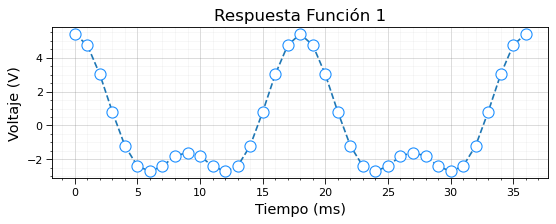

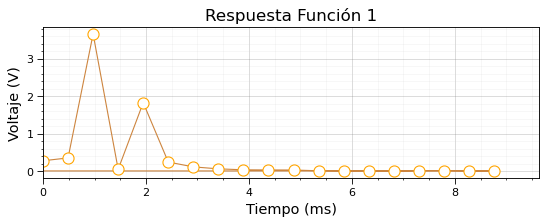

In [10]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(df['tiempo_ms'], df['f1'], linestyle='--', marker='o', markerfacecolor='white', markeredgecolor='dodgerblue', ms=10)

formato_grafica(titulo='Respuesta Función 1', 
                ejex='Tiempo (ms)', 
                ejey='Voltaje (V)',
                leyenda=False)

hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(frecs, An, linestyle='-', color='peru', linewidth=1, marker='o', markerfacecolor='white', markeredgecolor='orange', ms=10)

formato_grafica(titulo='Respuesta Función 1', 
                ejex='Tiempo (ms)', 
                ejey='Voltaje (V)',
                xlim=(0, None),
                leyenda=False)

In [11]:
# Amplitudes
n_picos = 2

max_An = np.unique(An[np.argpartition(An, -n_picos*2)[-n_picos*2:]])
max_An

array([1.83142292, 3.66489928])

In [12]:
# Ángulos de Fase
phi = np.angle(señal_fft)

# Ángulos de amplitudes
n_picos = 2

max_phi = np.unique(phi[np.argpartition(phi, -n_picos)[-n_picos:]])
max_phi

array([2.6321452 , 2.71705311])

Conocidos estos valores, podemos obtener la representación matemática de la DFT; esta es:

$$
\boxed{ f(t) = 3.66 \sin(2 \omega t) + 1.83 \sin(4 \omega t) }
$$

### 1.3.2. Señal 4

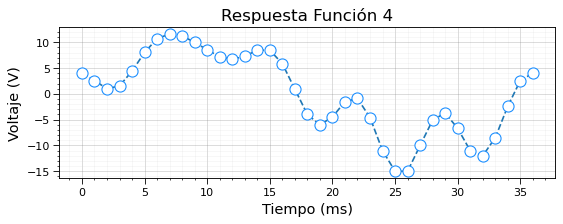

In [13]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(df['tiempo_ms'], df['f4'], linestyle='--', marker='o', markerfacecolor='white', markeredgecolor='dodgerblue', ms=10)

formato_grafica(titulo='Respuesta Función 4', 
                ejex='Tiempo (ms)', 
                ejey='Voltaje (V)',
                leyenda=False)

In [14]:
# Periodo
T = 36 # ms

# Cantidad de datos
N = len(df['f4'])

# Frecuencia de muestreo
delta_f = frec_muestreo(T) # Hz

# Frecuencia Circular
omega = freq_circular(T) # rad/s
omega

174.53292519943295

In [15]:
# PASO 1. Estimar la FFT
señal_fft = fft.fft(df['f4'].values)
señal_fft

array([ 3.03000000e+00-0.00000000e+00j,  1.96002131e+01-1.81868384e+02j,
        3.84840623e+00+8.40262340e+00j,  4.27148987e+00+6.50117615e+00j,
        8.15584390e+00+7.67492735e+00j,  6.38751477e+01+3.66272787e+01j,
       -2.75223879e+01+2.70247050e+01j, -4.13073199e-01-7.79832117e+00j,
       -5.17798671e-01-3.60628749e+00j, -9.99061932e-02-2.38340384e+00j,
        1.07164515e-01-1.14611314e+00j, -3.86971256e-01-1.01381004e+00j,
        3.26153323e-01-1.02286618e+00j, -4.36951259e-03-2.94762797e-01j,
       -1.65526398e-01-1.01323703e+00j,  7.61087392e-01-7.90114184e-01j,
        4.99686701e-01+4.24079739e-01j, -5.02262626e-01-5.86910578e-03j,
        6.52103007e-01-6.88976903e-01j,  6.52103007e-01+6.88976903e-01j,
       -5.02262626e-01+5.86910578e-03j,  4.99686701e-01-4.24079739e-01j,
        7.61087392e-01+7.90114184e-01j, -1.65526398e-01+1.01323703e+00j,
       -4.36951259e-03+2.94762797e-01j,  3.26153323e-01+1.02286618e+00j,
       -3.86971256e-01+1.01381004e+00j,  1.07164515

In [16]:
# PASO 2. Estimar las frecuencias
frecs = fftfreq(N, delta_f)
frecs

array([  0.        ,   0.97297297,   1.94594595,   2.91891892,
         3.89189189,   4.86486486,   5.83783784,   6.81081081,
         7.78378378,   8.75675676,   9.72972973,  10.7027027 ,
        11.67567568,  12.64864865,  13.62162162,  14.59459459,
        15.56756757,  16.54054054,  17.51351351, -17.51351351,
       -16.54054054, -15.56756757, -14.59459459, -13.62162162,
       -12.64864865, -11.67567568, -10.7027027 ,  -9.72972973,
        -8.75675676,  -7.78378378,  -6.81081081,  -5.83783784,
        -4.86486486,  -3.89189189,  -2.91891892,  -1.94594595,
        -0.97297297])

In [17]:
# PASO 3. Calcular la amplitud
An = (2/N) * abs(señal_fft)
An

array([0.16378378, 9.88764897, 0.49956683, 0.4204798 , 0.60536269,
       3.98007897, 2.08498512, 0.42212182, 0.19693358, 0.12894577,
       0.06222229, 0.05865693, 0.05803279, 0.01593487, 0.0554956 ,
       0.05930039, 0.03542625, 0.02715118, 0.05127811, 0.05127811,
       0.02715118, 0.03542625, 0.05930039, 0.0554956 , 0.01593487,
       0.05803279, 0.05865693, 0.06222229, 0.12894577, 0.19693358,
       0.42212182, 2.08498512, 3.98007897, 0.60536269, 0.4204798 ,
       0.49956683, 9.88764897])

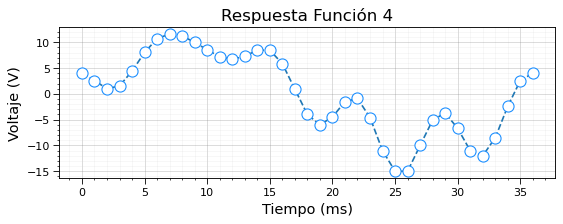

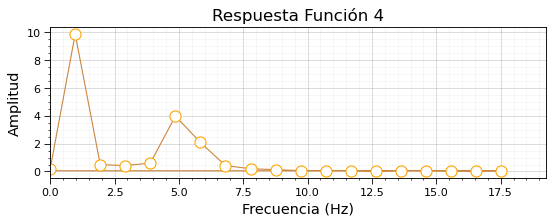

In [18]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(df['tiempo_ms'], df['f4'], linestyle='--', marker='o', markerfacecolor='white', markeredgecolor='dodgerblue', ms=10)

formato_grafica(titulo='Respuesta Función 4', 
                ejex='Tiempo (ms)', 
                ejey='Voltaje (V)',
                leyenda=False)

hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(frecs, An, linestyle='-', color='peru', linewidth=1, marker='o', markerfacecolor='white', markeredgecolor='orange', ms=10)

formato_grafica(titulo='Respuesta Función 4', 
                ejex='Frecuencia (Hz)', 
                ejey='Amplitud',
                xlim=(0, None),
                leyenda=False)

In [19]:
# Amplitudes
n_picos = 3

max_An = np.unique(An[np.argpartition(An, -n_picos*2)[-n_picos*2:]])
max_An

array([2.08498512, 3.98007897, 9.88764897])

In [20]:
# Ángulos de Fase
phi = np.angle(señal_fft)

# Ángulos de amplitudes
n_picos = 3

max_phi = np.unique(phi[np.argpartition(phi, -n_picos)[-n_picos:]])
max_phi

array([1.93542796, 2.36531815, 3.12990785])

Conocidos estos valores, podemos obtener la representación matemática de la DFT; esta es:

$$
\boxed{ f(t) = 9.88 \sin(\omega t + 3.12) + 3.98 \sin(5 \omega t + 2.36) + 2.08 \sin(6 \omega t + 1.93) }
$$

### 1.3.3. Señal 5

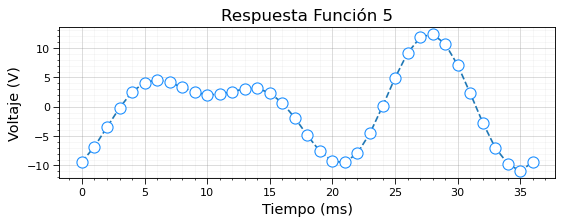

In [21]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(df['tiempo_ms'], df['f5'], linestyle='--', marker='o', markerfacecolor='white', markeredgecolor='dodgerblue', ms=10)

formato_grafica(titulo='Respuesta Función 5', 
                ejex='Tiempo (ms)', 
                ejey='Voltaje (V)',
                leyenda=False)

In [22]:
# Periodo
T = 36 # ms

# Cantidad de datos
N = len(df['f5'])

# Frecuencia de muestreo
delta_f = frec_muestreo(T) # Hz

# Frecuencia Circular
omega = freq_circular(T) # rad/s
omega

174.53292519943295

In [23]:
# PASO 1. Estimar la FFT
señal_fft = fft.fft(df['f5'].values)
señal_fft

array([-9.85000000e+00 -0.j        , -1.21700489e+01 -1.89576444j,
       -1.39232034e+02 -2.49793167j, -1.31119186e+01-92.78185092j,
        2.76563661e+00 +8.91015563j,  9.41416541e-01 +4.26467584j,
        4.71679470e-01 +2.72762327j,  1.63944655e-01 +2.14477846j,
       -8.74255442e-02 +1.60149614j, -2.05759065e-02 +1.48678246j,
       -3.90936788e-01 +1.36058421j, -3.85988241e-01 +1.22564645j,
       -7.15242884e-01 +1.19908105j, -7.48175680e-01 +1.09366601j,
       -1.02815892e+00 +1.10411115j, -1.17841272e+00 +0.91422133j,
       -1.26981460e+00 +0.70211025j, -1.42126960e+00 +0.54911628j,
       -1.55767499e+00 +0.16682825j, -1.55767499e+00 -0.16682825j,
       -1.42126960e+00 -0.54911628j, -1.26981460e+00 -0.70211025j,
       -1.17841272e+00 -0.91422133j, -1.02815892e+00 -1.10411115j,
       -7.48175680e-01 -1.09366601j, -7.15242884e-01 -1.19908105j,
       -3.85988241e-01 -1.22564645j, -3.90936788e-01 -1.36058421j,
       -2.05759065e-02 -1.48678246j, -8.74255442e-02 -1.601496

In [24]:
# PASO 2. Estimar las frecuencias
frecs = fftfreq(N, delta_f)
frecs

array([  0.        ,   0.97297297,   1.94594595,   2.91891892,
         3.89189189,   4.86486486,   5.83783784,   6.81081081,
         7.78378378,   8.75675676,   9.72972973,  10.7027027 ,
        11.67567568,  12.64864865,  13.62162162,  14.59459459,
        15.56756757,  16.54054054,  17.51351351, -17.51351351,
       -16.54054054, -15.56756757, -14.59459459, -13.62162162,
       -12.64864865, -11.67567568, -10.7027027 ,  -9.72972973,
        -8.75675676,  -7.78378378,  -6.81081081,  -5.83783784,
        -4.86486486,  -3.89189189,  -2.91891892,  -1.94594595,
        -0.97297297])

In [25]:
# PASO 3. Calcular la amplitud
An = (2/N) * abs(señal_fft)
An

array([0.53243243, 0.66577396, 7.527267  , 5.065068  , 0.50429744,
       0.23607284, 0.14962735, 0.11627217, 0.08669625, 0.08037431,
       0.07652078, 0.06945885, 0.07547014, 0.07162666, 0.08155129,
       0.08061954, 0.07843219, 0.08235993, 0.08468017, 0.08468017,
       0.08235993, 0.07843219, 0.08061954, 0.08155129, 0.07162666,
       0.07547014, 0.06945885, 0.07652078, 0.08037431, 0.08669625,
       0.11627217, 0.14962735, 0.23607284, 0.50429744, 5.065068  ,
       7.527267  , 0.66577396])

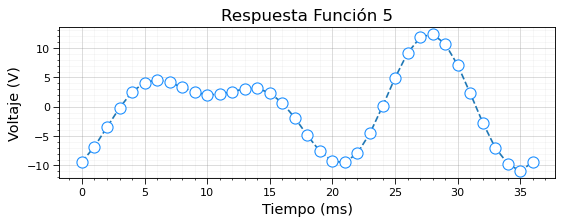

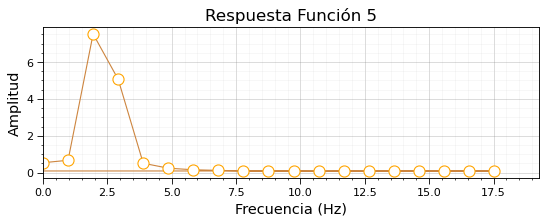

In [26]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(df['tiempo_ms'], df['f5'], linestyle='--', marker='o', markerfacecolor='white', markeredgecolor='dodgerblue', ms=10)

formato_grafica(titulo='Respuesta Función 5', 
                ejex='Tiempo (ms)', 
                ejey='Voltaje (V)',
                leyenda=False)

hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(frecs, An, linestyle='-', color='peru', linewidth=1, marker='o', markerfacecolor='white', markeredgecolor='orange', ms=10)

formato_grafica(titulo='Respuesta Función 5', 
                ejex='Frecuencia (Hz)', 
                ejey='Amplitud',
                xlim=(0, None),
                leyenda=False)

In [27]:
# Amplitudes
n_picos = 2

max_An = np.unique(An[np.argpartition(An, -n_picos*2)[-n_picos*2:]])
max_An

array([5.065068, 7.527267])

In [28]:
# Ángulos de Fase
phi = np.angle(señal_fft)

# Ángulos de amplitudes
n_picos = 2

max_phi = np.unique(phi[np.argpartition(phi, -n_picos)[-n_picos:]])
max_phi

array([3.03489855, 3.1236538 ])

Conocidos estos valores, podemos obtener la representación matemática de la DFT; esta es:

$$
\boxed{ f(t) = 7.52 \sin(2 \omega t + 3.14) + 5.06 \sin(3 \omega t + 3.12) }
$$

## 1.4. Ejemplo 2: Audio

Tenemos cuatro señales de audio independientes y una quinta que las combina todas. Vamos a ver cómo utilizando la librería `scipy.fft` podemos obtener la caracterización de cada una de las señales que componen el audio completo.

Dado que los audio son en formato WAV, debemos utilizar la misma librería `scipy.io.wavfile` para reconocerlos en Python.

<div class="alert alert-block alert-success">
    
**Nota:** Ejercicio tomado de MIT 18.S191 (2020), Introduction to Computational Thinking: Lecture 26 -- Discrete Fourier Transform. [online]. Disponible [aquí](https://www.youtube.com/watch?v=g8RkArhtCc4) y [aquí](https://github.com/mitmath/18S191/blob/Fall20/lecture_notebooks/week13/dft.jl).
</div>

<div class='alert alert-block alert-info'> 

<i class='fa fa-info-circle' aria-hidden='true'></i>
Puede obtener más información en la documentación oficial de la librería `scipy.io.wavfile` dando clic [aquí](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html).
</div>

In [29]:
from scipy.io import wavfile

_, data1 = wavfile.read('./data/Sound1.wav')
_, data2 = wavfile.read('./data/Sound2.wav')
_, data3 = wavfile.read('./data/Sound3.wav')
_, data4 = wavfile.read('./data/Sound4.wav')
_, data1234 = wavfile.read('./data/Sound1234.wav')

/var/folders/y_/9s04mk215pxfftn0yp96n17c0000gn/T/ipykernel_14952/1456328901.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data1 = wavfile.read('./data/Sound1.wav')
/var/folders/y_/9s04mk215pxfftn0yp96n17c0000gn/T/ipykernel_14952/1456328901.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data2 = wavfile.read('./data/Sound2.wav')
/var/folders/y_/9s04mk215pxfftn0yp96n17c0000gn/T/ipykernel_14952/1456328901.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data3 = wavfile.read('./data/Sound3.wav')
/var/folders/y_/9s04mk215pxfftn0yp96n17c0000gn/T/ipykernel_14952/1456328901.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data4 = wavfile.read('./data/Sound4.wav')
/var/folders/y_/9s04mk215pxfftn0yp96n17c0000gn/T/ipykernel_14952/1456328901.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data1234 = wavfile.read('./data/Sound1234.wav')


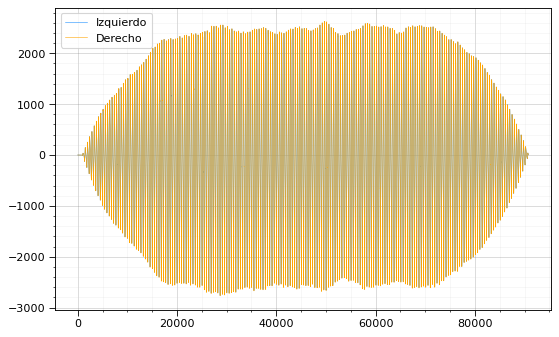

In [30]:
hor = 8
ver = 5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(data1[:,0], linestyle='-', linewidth=0.5, color='dodgerblue', label='Izquierdo')
plt.plot(data1[:,1], linestyle='-', linewidth=0.5, color='orange', label='Derecho')

formato_grafica(titulo='', 
                ejex='', 
                ejey='',
                leyenda=True)

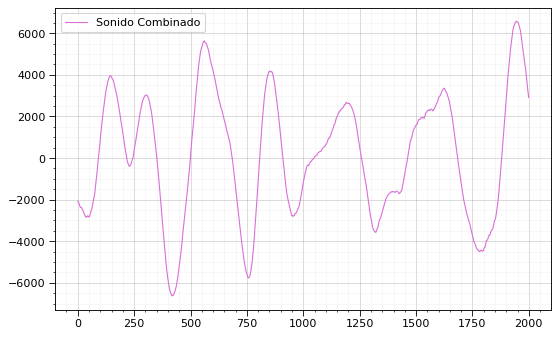

In [31]:
# Visualización de la señal combinada
hor = 8
ver = 5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(data1234[:,0][20000:22000], linestyle='-', linewidth=1, color='orchid', label='Sonido Combinado')

formato_grafica(titulo='', 
                ejex='', 
                ejey='',
                leyenda=True)

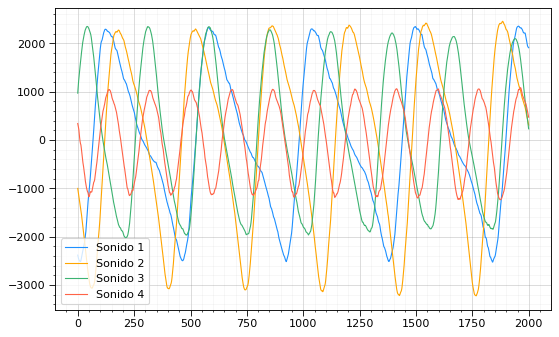

In [32]:
# Visualización de las señales
hor = 8
ver = 5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(data1[:,0][20000:22000], linestyle='-', linewidth=1, color='dodgerblue', label='Sonido 1')
plt.plot(data2[:,0][20000:22000], linestyle='-', linewidth=1, color='orange', label='Sonido 2')
plt.plot(data3[:,0][20000:22000], linestyle='-', linewidth=1, color='mediumseagreen', label='Sonido 3')
plt.plot(data4[:,0][20000:22000], linestyle='-', linewidth=1, color='tomato', label='Sonido 4')

formato_grafica(titulo='', 
                ejex='', 
                ejey='',
                leyenda=True)

In [33]:
# PASO 1. Estimar la FFT
señal_fft1 = fft.fft(data1[:,0])
señal_fft2 = fft.fft(data2[:,0])
señal_fft3 = fft.fft(data3[:,0])
señal_fft4 = fft.fft(data4[:,0])

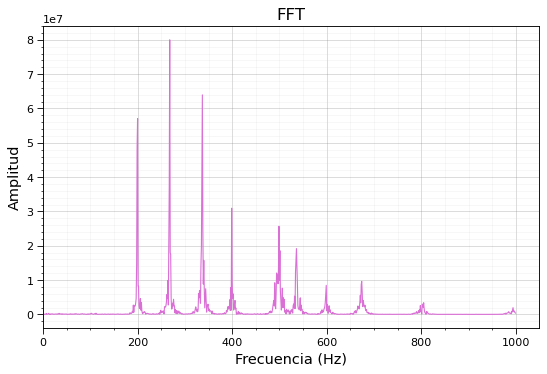

In [34]:
# FFT señal combinada
señal_fft1234 = fft.fft(data1234[:,0])

# Gráfica
hor = 8
ver = 5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(np.abs(señal_fft1234[0:1000]), linestyle='-', color='orchid', linewidth=1)

formato_grafica(titulo='FFT', 
                ejex='Frecuencia (Hz)', 
                ejey='Amplitud',
                xlim=(0, None),
                leyenda=False)

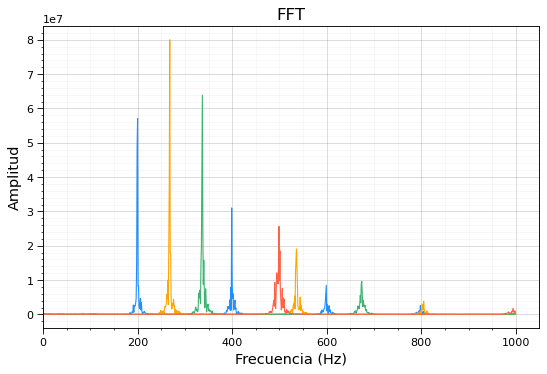

In [35]:
hor = 8
ver = 5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(np.abs(señal_fft1[0:1000]), linestyle='-', color='dodgerblue', linewidth=1)
plt.plot(np.abs(señal_fft2[0:1000]), linestyle='-', color='orange', linewidth=1)
plt.plot(np.abs(señal_fft3[0:1000]), linestyle='-', color='mediumseagreen', linewidth=1)
plt.plot(np.abs(señal_fft4[0:1000]), linestyle='-', color='tomato', linewidth=1)

formato_grafica(titulo='FFT', 
                ejex='Frecuencia (Hz)', 
                ejey='Amplitud',
                xlim=(0, None),
                leyenda=False)

De lo anterior, notemos que **la FFT extrae los componentes de frecuencia de cada sonido**, en donde podemos asociar las notas musicales a los picos de frecuencia de cada señal, siendo los picos más pequeños los armónicos (múltiplos de números enteros de esa frecuencia principal).

En este caso, decimos \"frecuencia\", a menos que cambiemos la escala del eje x, no serán ciclos por unidad de tiempo, sino ciclos por $T$ unidades de tiempo, donde $T$ es la duración del audio.

La FFT solo ve una lista de valores de muestra, no tiene forma de saber cuántas muestras por segundo hay, o si los segundos son la unidad de tiempo que nos interesa, por lo que la única unidad de tiempo sería la duración del audio.

Comentarios de MIT 18.S191 (2020).

<img src='./img/notas.jpeg' width='700' height='700'/>

<a id="section2"></a>
# Sección 2: Sistemas Dinámicos

## 2.1. Introducción

Tengamos presentes las siguientes equivalencias:

#### Movimiento Rectilíneo
$$
\begin{cases}
  v = \frac{dx}{dt} = \dot{x} \\ 
  \\
  a = \frac{dv}{dt} = \frac{d}{dt} \left( \frac{dx}{dt} \right) = \frac{d^2x}{dt^2} = \ddot{x} \\
\end{cases} 
$$

#### Movimiento Rotacional
$$
\begin{cases}
  \omega = \frac{d \theta}{dt} = \dot{\theta} \\ 
  \\
  \alpha = \frac{d \omega}{dt} = \frac{d}{dt} \left( \frac{d \theta}{dt} \right) = \frac{d^2 \theta}{dt^2} = \ddot{\theta} \\
\end{cases} 
$$

#### Generalización 2da Ley de Newton
$$
\begin{cases}
  F = ma \rightarrow F = m \ddot{x} & (1) \\ 
  \\
  T = I \alpha \rightarrow T = I \ddot{\theta} & (2) \\
\end{cases} 
$$

Siendo $F$ la fuerza, $m$ la masa, $a$ la aceleración, $T$ el torque, $I$ el momento de inercia (en nuestros casos de estudio, $I = m L^2$, siendo $L$ la longitud al punto de pivote del giro) y $\theta$ el ángulo de giro.

## 2.2. Ejemplo 1: Péndulo Simple

<img src='./img/pendulum1.png' width='300' height='300'/>

Partimos de la relación:

$$
T = I \ddot{\theta}
$$

El único componente de la masa que causa un torque en el cuerpo es:

$$
m g \sin \theta
$$

Luego:

$$
\boxed{ \ddot{\theta} + \frac{g}{L} \sin \theta = 0 }
$$

<div class='alert alert-block alert-info'> 

<i class='fa fa-info-circle' aria-hidden='true'></i>
Puede obtener más información del ejercicio dando clic [aquí](https://www.youtube.com/watch?v=8VJ1CJ55Np0) y [aquí](https://www.youtube.com/watch?v=xBBXlQ7CmFc).
</div>

In [36]:
# PASO 1. Definir la función
def pendulo_simple(variables, t, g, L):
    # Variables
    theta = variables[0]
    dtheta_dt = variables[1]
    
    # Ecuaciones
    d2theta_dt2 = -(g/L) * np.sin(np.deg2rad(theta))
    
    return [dtheta_dt, d2theta_dt2]

pendulo_simple

<function __main__.pendulo_simple(variables, t, g, L)>

In [37]:
# PASO 2. Condiciones iniciales
condiciones_iniciales = [30, 0] # [x0, dx_dt0]
condiciones_iniciales

[30, 0]

In [38]:
# PASO 3. Puntos de tiempo
start = 0
stop = 200
num = 1000

tiempo = np.linspace(start, stop, num)
tiempo

array([  0.        ,   0.2002002 ,   0.4004004 ,   0.6006006 ,
         0.8008008 ,   1.001001  ,   1.2012012 ,   1.4014014 ,
         1.6016016 ,   1.8018018 ,   2.002002  ,   2.2022022 ,
         2.4024024 ,   2.6026026 ,   2.8028028 ,   3.003003  ,
         3.2032032 ,   3.4034034 ,   3.6036036 ,   3.8038038 ,
         4.004004  ,   4.2042042 ,   4.4044044 ,   4.6046046 ,
         4.8048048 ,   5.00500501,   5.20520521,   5.40540541,
         5.60560561,   5.80580581,   6.00600601,   6.20620621,
         6.40640641,   6.60660661,   6.80680681,   7.00700701,
         7.20720721,   7.40740741,   7.60760761,   7.80780781,
         8.00800801,   8.20820821,   8.40840841,   8.60860861,
         8.80880881,   9.00900901,   9.20920921,   9.40940941,
         9.60960961,   9.80980981,  10.01001001,  10.21021021,
        10.41041041,  10.61061061,  10.81081081,  11.01101101,
        11.21121121,  11.41141141,  11.61161161,  11.81181181,
        12.01201201,  12.21221221,  12.41241241,  12.61

In [39]:
# PASO 4. Solcionar ODE
## Constantes
g = 9.81
L = 5.0

## Solución numérica
sol = integrate.odeint(func=pendulo_simple, 
                       y0=condiciones_iniciales, 
                       t=tiempo,
                       args=(g, L))

sol

array([[30.        ,  0.        ],
       [29.98034265, -0.19635748],
       [29.92139397, -0.39248153],
       ...,
       [ 5.26781803,  5.40108835],
       [ 6.34526135,  5.36134563],
       [ 7.41401497,  5.31429067]])

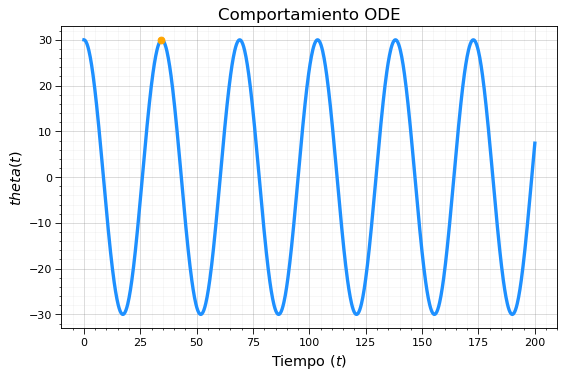

In [40]:
# Gráfica
hor = 8
ver = 5
fig1 = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(tiempo, sol[:,0], linestyle='-', linewidth=3, color='dodgerblue', label='Solución Numérica')
plt.scatter(tiempo[170], sol[:,0][170], color='orange', zorder=5)

formato_grafica(titulo='Comportamiento ODE', 
                ejex='Tiempo ($t$)', 
                ejey='$theta(t)$',
                leyenda=False)

In [41]:
# FFT
# Periodo
T = tiempo[170] # ms

# Cantidad de datos
N = len(sol[:,1])

# Frecuencia de muestreo
deltaf = frec_muestreo(T) # Hz
print(f'Frecuencia Muestreo: {np.round(delta_f, 2)} Hz')

# Frecuencia Circular
omega = freq_circular(T) # rad/s
print(f'Frecuencia Circular: {np.round(omega, 2)} rad/s')

Frecuencia Muestreo: 0.03 Hz
Frecuencia Circular: 184.61 rad/s


In [42]:
# PASO 1. Estimar la FFT
señal_fft = fft.fft(sol[:,0])
señal_fft

array([ -781.26151557-0.00000000e+00j,  -805.56293238+1.05488144e+02j,
        -888.32354559+2.32374432e+02j, -1071.13933987+4.19464581e+02j,
       -1501.72507938+7.81954104e+02j, -3087.00562638+2.00220560e+03j,
       11026.21167251-8.54525635e+03j,  1735.87902798-1.56169865e+03j,
         884.93978617-9.04724050e+02j,   571.39784799-6.53049244e+02j,
         410.89895709-5.18202194e+02j,   314.65393353-4.33288709e+02j,
         251.21538955-3.74473275e+02j,   206.65343217-3.31128332e+02j,
         173.85318233-2.97829045e+02j,   148.76511631-2.71636409e+02j,
         128.71310641-2.51374841e+02j,   109.00736846-2.44246203e+02j,
         106.07246637-2.02828149e+02j,    93.42710118-1.95378652e+02j,
          84.24330663-1.84960285e+02j,    76.69954576-1.75149976e+02j,
          70.33256044-1.66221714e+02j,    64.88275258-1.58134722e+02j,
          60.17119455-1.50798159e+02j,    56.0649083 -1.44120149e+02j,
          52.46137014-1.38018538e+02j,    49.27971555-1.32422435e+02j,
      

In [43]:
# PASO 2. Estimar las frecuencias
frecs = fftfreq(N, delta_f)
frecs

array([  0.   ,   0.036,   0.072,   0.108,   0.144,   0.18 ,   0.216,
         0.252,   0.288,   0.324,   0.36 ,   0.396,   0.432,   0.468,
         0.504,   0.54 ,   0.576,   0.612,   0.648,   0.684,   0.72 ,
         0.756,   0.792,   0.828,   0.864,   0.9  ,   0.936,   0.972,
         1.008,   1.044,   1.08 ,   1.116,   1.152,   1.188,   1.224,
         1.26 ,   1.296,   1.332,   1.368,   1.404,   1.44 ,   1.476,
         1.512,   1.548,   1.584,   1.62 ,   1.656,   1.692,   1.728,
         1.764,   1.8  ,   1.836,   1.872,   1.908,   1.944,   1.98 ,
         2.016,   2.052,   2.088,   2.124,   2.16 ,   2.196,   2.232,
         2.268,   2.304,   2.34 ,   2.376,   2.412,   2.448,   2.484,
         2.52 ,   2.556,   2.592,   2.628,   2.664,   2.7  ,   2.736,
         2.772,   2.808,   2.844,   2.88 ,   2.916,   2.952,   2.988,
         3.024,   3.06 ,   3.096,   3.132,   3.168,   3.204,   3.24 ,
         3.276,   3.312,   3.348,   3.384,   3.42 ,   3.456,   3.492,
         3.528,   3.

In [44]:
# PASO 3. Calcular la amplitud
An = (2/N) * abs(señal_fft)
An

array([1.56252303e+00, 1.62488078e+00, 1.83642762e+00, 2.30068687e+00,
       3.38622529e+00, 7.35892139e+00, 2.78997312e+01, 4.66998016e+00,
       2.53112152e+00, 1.73547552e+00, 1.32268132e+00, 1.07097377e+00,
       9.01863418e-01, 7.80644896e-01, 6.89716084e-01, 6.19410683e-01,
       5.64823421e-01, 5.34934815e-01, 4.57779974e-01, 4.33134810e-01,
       4.06483661e-01, 3.82415138e-01, 3.60978266e-01, 3.41855887e-01,
       3.24719309e-01, 3.09282340e-01, 2.95305348e-01, 2.82589395e-01,
       2.70968958e-01, 2.60354178e-01, 2.50489473e-01, 2.41413568e-01,
       2.32999178e-01, 2.25174904e-01, 2.17879496e-01, 2.11060005e-01,
       2.04670403e-01, 1.98670485e-01, 1.93024971e-01, 1.87702779e-01,
       1.82676475e-01, 1.77920993e-01, 1.73415681e-01, 1.69140331e-01,
       1.65077584e-01, 1.61211723e-01, 1.57528559e-01, 1.54015250e-01,
       1.50660147e-01, 1.47452652e-01, 1.44383106e-01, 1.41442684e-01,
       1.38623306e-01, 1.35917575e-01, 1.33318670e-01, 1.30820327e-01,
      

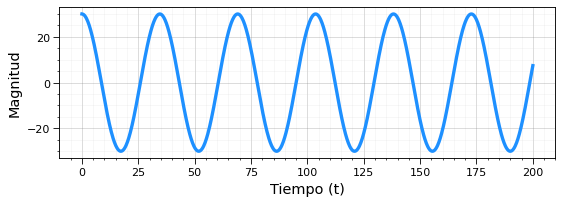

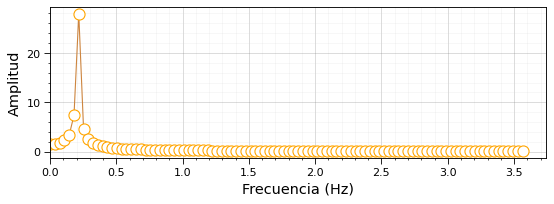

In [45]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(tiempo, sol[:,0], linestyle='-', linewidth=3, color='dodgerblue', label='Solución Numérica')

formato_grafica(titulo='', 
                ejex='Tiempo (t)', 
                ejey='Magnitud',
                leyenda=False)

hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(frecs[0:100], An[0:100], linestyle='-', color='peru', linewidth=1, marker='o', markerfacecolor='white', markeredgecolor='orange', ms=10)

formato_grafica(titulo='', 
                ejex='Frecuencia (Hz)', 
                ejey='Amplitud',
                xlim=(0, None),
                leyenda=False)

In [46]:
# Amplitudes
n_picos = 3

max_An = np.unique(An[np.argpartition(An, -n_picos*2)[-n_picos*2:]])
max_An

array([ 4.66998016,  7.35892139, 27.89973118])

In [47]:
# Ángulos de Fase
phi = np.angle(señal_fft)

# Ángulos de amplitudes
n_picos = 3

max_phi = np.unique(phi[np.argpartition(phi, -n_picos)[-n_picos:]])
max_phi

array([2.76834337, 2.88573809, 3.01138394])

Conocidos estos valores, podemos obtener la representación matemática de la DFT; para el armónico principal, esta es:

$$
\boxed{ f(t) = 27.89 \sin(3 \omega t + 3.14) }
$$

## 2.3. Ejemplo 2: Péndulo Simple + Fricción + Fuerza Externa

<img src='./img/pendulum2.png' width='800' height='800'/>

Este caso es una extensión al Ejemplo 1, pues:

$$
F = m a
$$

Luego:

$$
F_0 \cos(\omega t) - mg \sin(\theta) - c \frac{ds}{dt} = ma 
$$

Entonces:

$$
F_0 \cos(\omega t) = m L \ddot{\theta} + c L \dot{\theta} + mg \sin(\theta)
$$

Que se puede reescribir como:

$$
\boxed{ \ddot{\theta} + \alpha \dot{\theta} + \sin(\theta) = \gamma \cos(\beta t) }
$$

Donde:

$$
\begin{cases}
  \alpha = \frac{c}{m \omega_0} \\ 
  \\
  \beta = \frac{\omega}{\omega_0} \\
  \\
  \gamma = \frac{F_0}{m L \omega_0^2}
\end{cases} 
$$

<div class='alert alert-block alert-info'> 

<i class='fa fa-info-circle' aria-hidden='true'></i>
Puede obtener más información del ejercicio dando clic [aquí](https://www.youtube.com/watch?v=SZWn7x4g-Vo).
</div>

In [48]:
# PASO 1. Definir la función
def pendulo_friccion(variables, t, alpha, beta, gamma):
    # Variables
    theta = variables[0]
    dtheta = variables[1]
    
    # Ecuaciones
    d2theta = -alpha*dtheta - np.sin(np.deg2rad(theta)) + gamma*np.cos(np.deg2rad(beta*t))
    
    return [dtheta, d2theta]

pendulo_friccion

<function __main__.pendulo_friccion(variables, t, alpha, beta, gamma)>

In [49]:
# PASO 2. Condiciones iniciales
condiciones_iniciales = [30, 0] # [x0, dx_dt0]
condiciones_iniciales

[30, 0]

In [50]:
# PASO 3. Puntos de tiempo
start = 0
stop = 1000
num = 1000

tiempo = np.linspace(start, stop, num)
tiempo

array([   0.        ,    1.001001  ,    2.002002  ,    3.003003  ,
          4.004004  ,    5.00500501,    6.00600601,    7.00700701,
          8.00800801,    9.00900901,   10.01001001,   11.01101101,
         12.01201201,   13.01301301,   14.01401401,   15.01501502,
         16.01601602,   17.01701702,   18.01801802,   19.01901902,
         20.02002002,   21.02102102,   22.02202202,   23.02302302,
         24.02402402,   25.02502503,   26.02602603,   27.02702703,
         28.02802803,   29.02902903,   30.03003003,   31.03103103,
         32.03203203,   33.03303303,   34.03403403,   35.03503504,
         36.03603604,   37.03703704,   38.03803804,   39.03903904,
         40.04004004,   41.04104104,   42.04204204,   43.04304304,
         44.04404404,   45.04504505,   46.04604605,   47.04704705,
         48.04804805,   49.04904905,   50.05005005,   51.05105105,
         52.05205205,   53.05305305,   54.05405405,   55.05505506,
         56.05605606,   57.05705706,   58.05805806,   59.05905

In [51]:
# PASO 4. Solcionar ODE
## Constantes
c = 0.5
m = 2.0
omega = 50.0
beta = 0.98
F = 150
L = 8.0

alpha = c / (m*omega)
gamma = F / (m*L*(omega**2))

## Solución numérica
sol = integrate.odeint(func=pendulo_friccion, 
                       y0=condiciones_iniciales, 
                       t=tiempo,
                       args=(alpha, beta, gamma))

sol

array([[30.        ,  0.        ],
       [29.75210539, -0.49425513],
       [29.01382161, -0.97855868],
       ...,
       [ 1.9890484 ,  0.17611783],
       [ 2.14667782,  0.13840891],
       [ 2.26542283,  0.09854181]])

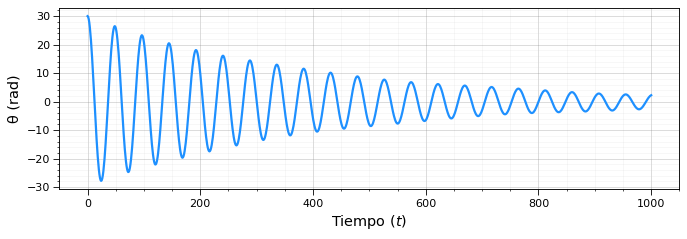

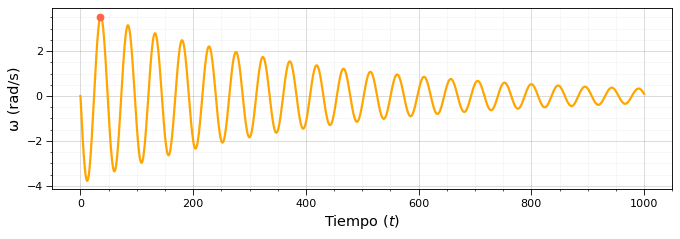

In [52]:
# Gráfica
hor = 10
ver = 3

# Ángulo
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(tiempo, sol[:,0], linestyle='-', linewidth=2, color='dodgerblue', label='Solución Numérica')

formato_grafica(titulo='', 
                ejex='Tiempo ($t$)', 
                ejey='θ (rad)',
                leyenda=False)

# Velocidad Angular
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(tiempo, sol[:,1], linestyle='-', linewidth=2, color='orange', label='Solución Numérica')
plt.scatter(tiempo[35], sol[:,1][35], color='tomato', zorder=5)

formato_grafica(titulo='', 
                ejex='Tiempo ($t$)', 
                ejey='ω (rad/s)',
                leyenda=False)

In [53]:
# FFT
# Periodo
T = tiempo[35] # ms

# Cantidad de datos
N = len(sol[:,1])

# Frecuencia de muestreo
deltaf = frec_muestreo(T) # Hz
print(f'Frecuencia Muestreo: {np.round(delta_f, 2)} Hz')

# Frecuencia Circular
omega = freq_circular(T) # rad/s
print(f'Frecuencia Circular: {np.round(omega, 2)} rad/s')

Frecuencia Muestreo: 0.03 Hz
Frecuencia Circular: 179.34 rad/s


In [54]:
# PASO 1. Estimar la FFT
señal_fft = fft.fft(sol[:,1])
señal_fft

array([-2.76195589e+01-0.00000000e+00j, -2.77249465e+01-5.43521267e-02j,
       -2.81807773e+01-2.59862611e-01j, -2.67467402e+01+1.24754869e+00j,
       -2.81898195e+01+4.35513158e-01j, -2.89401803e+01+3.72804234e-01j,
       -2.98000109e+01+3.85355836e-01j, -3.08482865e+01+4.30779703e-01j,
       -3.21364835e+01+5.02712637e-01j, -3.37230425e+01+6.04181977e-01j,
       -3.56853916e+01+7.44123285e-01j, -3.81320679e+01+9.38496121e-01j,
       -4.12211629e+01+1.21446510e+00j, -4.51920587e+01+1.61950729e+00j,
       -5.04241758e+01+2.24131503e+00j, -5.75537782e+01+3.25500346e+00j,
       -6.77240577e+01+5.04325630e+00j, -8.32052417e+01+8.57681276e+00j,
       -1.09019659e+02+1.68039238e+01j, -1.57887888e+02+4.13993455e+01j,
       -2.60010574e+02+1.51297664e+02j,  1.33930536e+02+6.98263142e+02j,
        2.19118324e+02+4.99291462e+01j,  1.15194025e+02+1.66083479e+01j,
        7.82312136e+01+9.16115540e+00j,  5.88431770e+01+5.92727028e+00j,
        4.68269780e+01+4.19584837e+00j,  3.86424848

In [55]:
# PASO 2. Estimar las frecuencias
frecs = fftfreq(N, delta_f)
frecs

array([  0.   ,   0.036,   0.072,   0.108,   0.144,   0.18 ,   0.216,
         0.252,   0.288,   0.324,   0.36 ,   0.396,   0.432,   0.468,
         0.504,   0.54 ,   0.576,   0.612,   0.648,   0.684,   0.72 ,
         0.756,   0.792,   0.828,   0.864,   0.9  ,   0.936,   0.972,
         1.008,   1.044,   1.08 ,   1.116,   1.152,   1.188,   1.224,
         1.26 ,   1.296,   1.332,   1.368,   1.404,   1.44 ,   1.476,
         1.512,   1.548,   1.584,   1.62 ,   1.656,   1.692,   1.728,
         1.764,   1.8  ,   1.836,   1.872,   1.908,   1.944,   1.98 ,
         2.016,   2.052,   2.088,   2.124,   2.16 ,   2.196,   2.232,
         2.268,   2.304,   2.34 ,   2.376,   2.412,   2.448,   2.484,
         2.52 ,   2.556,   2.592,   2.628,   2.664,   2.7  ,   2.736,
         2.772,   2.808,   2.844,   2.88 ,   2.916,   2.952,   2.988,
         3.024,   3.06 ,   3.096,   3.132,   3.168,   3.204,   3.24 ,
         3.276,   3.312,   3.348,   3.384,   3.42 ,   3.456,   3.492,
         3.528,   3.

In [56]:
# PASO 3. Calcular la amplitud
An = (2/N) * abs(señal_fft)
An

array([5.52391177e-02, 5.54499995e-02, 5.63639508e-02, 5.35516382e-02,
       5.63863670e-02, 5.78851627e-02, 5.96050048e-02, 6.17025883e-02,
       6.42808306e-02, 6.74569086e-02, 7.13862982e-02, 7.62872303e-02,
       8.24780987e-02, 9.04421356e-02, 1.00947927e-01, 1.15291499e-01,
       1.35823156e-01, 1.67292247e-01, 2.20614213e-01, 3.26450554e-01,
       6.01652663e-01, 1.42198285e+00, 4.49469730e-01, 2.32770278e-01,
       1.57531578e-01, 1.18281901e-01, 9.40291659e-02, 7.75423657e-02,
       6.56273227e-02, 5.66222276e-02, 4.95882762e-02, 4.39509716e-02,
       3.93391037e-02, 3.55022014e-02, 3.22652836e-02, 2.95026173e-02,
       2.71218646e-02, 2.50533219e-02, 2.32359441e-02, 2.15542043e-02,
       2.00504018e-02, 1.88094342e-02, 1.76808988e-02, 1.66590532e-02,
       1.57099414e-02, 1.47539763e-02, 1.39981310e-02, 1.33056023e-02,
       1.26629112e-02, 1.20700940e-02, 1.15239255e-02, 1.10209460e-02,
       1.05581100e-02, 1.01329931e-02, 9.74392011e-03, 9.39014884e-03,
      

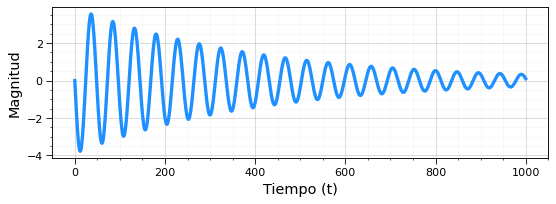

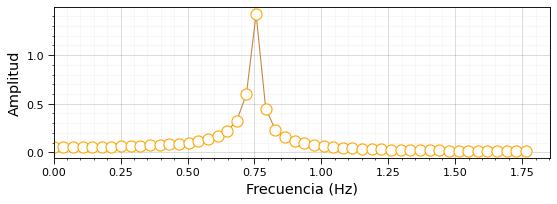

In [57]:
hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(tiempo, sol[:,1], linestyle='-', linewidth=3, color='dodgerblue', label='Solución Numérica')

formato_grafica(titulo='', 
                ejex='Tiempo (t)', 
                ejey='Magnitud',
                leyenda=False)

hor = 8
ver = 2.5
fig = plt.figure(figsize=(hor, ver), dpi=80)

plt.plot(frecs[0:50], An[0:50], linestyle='-', color='peru', linewidth=1, marker='o', markerfacecolor='white', markeredgecolor='orange', ms=10)

formato_grafica(titulo='', 
                ejex='Frecuencia (Hz)', 
                ejey='Amplitud',
                xlim=(0, None),
                leyenda=False)

In [58]:
# Amplitudes
n_picos = 4

max_An = np.unique(An[np.argpartition(An, -n_picos*2)[-n_picos*2:]])
max_An

array([0.32645055, 0.44946973, 0.60165266, 1.42198285])

In [59]:
# Ángulos de Fase
phi = np.angle(señal_fft)

# Ángulos de amplitudes
n_picos = 4

max_phi = np.unique(phi[np.argpartition(phi, -n_picos)[-n_picos:]])
max_phi

array([3.12866198, 3.12871148, 3.13237164, 3.13963225])

Conocidos estos valores, podemos obtener la representación matemática de la DFT; para el armónico principal, esta es:

$$
\boxed{ f(t) = 3.13 \sin(22 \omega t + 1.42) }
$$